In [1]:
# Libraries
import pyspark
from os import listdir
from os.path import isfile, join
import boto3
import pandas as pd
from sagemaker import get_execution_role
from pyspark.sql.types import LongType, StringType, StructField, StructType, BooleanType, ArrayType, IntegerType

In [2]:
# Spark Environment
conf = pyspark.SparkConf().setAppName('odl').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
sqlc = pyspark.sql.SQLContext(sc)
sc

<SparkContext master=local appName=odl>

In [3]:
sqlc

In [51]:
role = get_execution_role()
bucket='odl-spark19spds6003-001'
data_key = 'bs7md/methanol.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
pddf = pd.read_csv(data_location)

In [52]:
pddf

,y,x1,x2,x3,x4,x5
0,1.1,0,454,8.8,3.90,1.30
1,4.2,0,474,8.2,3.68,1.16
2,94.2,0,524,7.0,2.78,1.25
3,20.7,0,503,7.4,2.27,1.57
4,15.7,0,493,7.6,2.40,1.55
5,15.9,0,493,7.6,1.28,2.71
6,14.7,0,493,7.5,5.68,0.54
7,10.8,0,493,7.6,4.65,0.74
8,9.6,0,493,7.4,3.30,1.01
9,12.7,0,493,7.4,2.52,1.12


In [53]:
df = sqlc.createDataFrame(pd.read_csv(data_location))

In [54]:
df

DataFrame[y: double, x1: bigint, x2: bigint, x3: double, x4: double, x5: double]

In [55]:
parquetPath = '/home/ec2-user/SageMaker/bs7md-hw1-pqt'
df.write.parquet(parquetPath)

AnalysisException: 'path file:/home/ec2-user/SageMaker/bs7md-hw1-pqt already exists.;'

In [57]:
# prep list of files to transfer
files = [f for f in listdir(parquetPath) if isfile(join(parquetPath, f))]

s3 = boto3.resource('s3')
for f in files:
    #print('copying {} to {}'.format(parquetPath+'/'+f,"sample_data/"+f))
    s3.Bucket(bucket).upload_file(parquetPath+'/'+f, "bs7md/"+f)


In [58]:
df = sqlc.read.parquet(parquetPath)

In [59]:
df

DataFrame[y: double, x1: bigint, x2: bigint, x3: double, x4: double, x5: double]

In [60]:
pddf = pddf.dropna()

In [61]:
df = sqlc.createDataFrame(pddf)

In [62]:
df.printSchema()

root
 |-- y: double (nullable = true)
 |-- x1: long (nullable = true)
 |-- x2: long (nullable = true)
 |-- x3: double (nullable = true)
 |-- x4: double (nullable = true)
 |-- x5: double (nullable = true)



In [63]:
# Linear model with x5
df = df.select('y','x5')

In [64]:
df.printSchema()

root
 |-- y: double (nullable = true)
 |-- x5: double (nullable = true)



In [65]:
# create train/test sets
seed = 42
(testDF, trainingDF) = df.randomSplit((0.20, 0.80), seed=seed)
print ('training set N = {}, test set N = {}'.format(trainingDF.count(),testDF.count()))

training set N = 14, test set N = 4


In [66]:
from pyspark.ml.linalg import Vectors, VectorUDT # nb: bad form, done for pedagogy

In [67]:
# make a user defined function (udf)
sqlc.registerFunction("oneElementVec", lambda d: Vectors.dense([d]), returnType=VectorUDT())

# vectorize the data frames
trainingDF = trainingDF.selectExpr("y", "oneElementVec(x5) as x5")
testDF = testDF.selectExpr("y", "oneElementVec(x5) as x5")

print(testDF.orderBy(testDF.y.desc()).limit(5))

DataFrame[y: double, x5: vector]


In [68]:
# rename to make ML engine happy
trainingDF = trainingDF.withColumnRenamed("y", "label").withColumnRenamed("x5", "features")
testDF = testDF.withColumnRenamed("y", "label").withColumnRenamed("x5", "features")

In [69]:
# Machine Learning
from pyspark.ml.regression import LinearRegression, LinearRegressionModel

lr = LinearRegression()
lrModel = lr.fit(trainingDF)

In [70]:
type(lrModel)

pyspark.ml.regression.LinearRegressionModel

In [71]:
predictionsAndLabelsDF = lrModel.transform(testDF)

print(predictionsAndLabelsDF.orderBy(predictionsAndLabelsDF.label.desc()).take(5))

[Row(label=15.9, features=DenseVector([2.71]), prediction=97.5005349381476), Row(label=15.7, features=DenseVector([1.55]), prediction=54.06355733868267), Row(label=10.8, features=DenseVector([0.74]), prediction=23.732564359745947), Row(label=9.6, features=DenseVector([1.01]), prediction=33.84289535272485)]


In [72]:
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator()
print(eval.explainParams())

labelCol: label column name. (default: label)
metricName: metric name in evaluation - one of:
                       rmse - root mean squared error (default)
                       mse - mean squared error
                       r2 - r^2 metric
                       mae - mean absolute error. (default: rmse)
predictionCol: prediction column name. (default: prediction)


In [73]:
type(eval)

pyspark.ml.evaluation.RegressionEvaluator

In [74]:
eval.setMetricName("rmse").evaluate(predictionsAndLabelsDF)

47.131144241022774

In [75]:
eval.setMetricName("r2").evaluate(predictionsAndLabelsDF)

-275.80308504275314

In [76]:
## Data Visualizatioon
import matplotlib.pyplot as plt

In [77]:
prediction = predictionsAndLabelsDF[2]

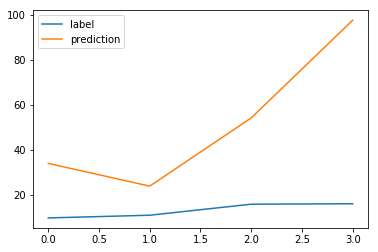

In [78]:
label = predictionsAndLabelsDF.toPandas()['label']
prediction=predictionsAndLabelsDF.toPandas()['prediction']
plt.plot(label)
plt.plot(prediction)
plt.legend()
plt.show()

In [ ]:
## Obviously this is a bad model since there are too few data points (only 14 in the training set)
## The mechanism works fine though